# MAKESHIFT TITLE
### Jake Andersen-Lum, Stephen Hong, Yicheng Huang, Ella Ren
### STAT301: Statistical Modelling for Data Science
### March 31, 2025

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(modelr)
library(pROC)
library(rsample)
library(caret)
library(glmnet)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    l

## Introduction

As technology develops, an increasing number of users choose to use email as a method of communication. At the same time, the number of unsolicited spam emails has grown. This not only makes mailboxes cluttered and causes users to miss important emails, but it is also a burden on the ISP's system (Cranor & LaMacchia, 1998). Therefore, predicting spam is an important way to guarantee user access and maintain the integrity of the email system.

Our research question is: Can we accurately predict whether an email is spam using the variables in our [email](https://www.openintro.org/data/index.php?data=email) dataset? The primary goal of this paper is prediction, and we hope to build a model that can accurately identify spam by using these features.

## Methods and Results

#### a) Data

The dataset is called [email](https://www.openintro.org/data/index.php?data=email), which is sourced from OpenIntro, and the source is the first three months of 2012 for David Diez's Gmail Account.
The dataset contains 3921 observations and 21 variables focusing on the information of incoming emails. This is an observational data.

**Citation**: [email](https://www.openintro.org/data/index.php?data=email)

In [2]:
# Loaded the data from an open source
email <- read_csv(url("https://www.openintro.org/data/csv/email.csv"))

Rows: 3921 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): winner, number
dbl  (18): spam, to_multiple, from, cc, sent_email, image, attach, dollar, i...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Variables information

| Variable Name    | Type | Description |
|---------|-----|-------|
| spam   | Categorical  |  Indicator for whether the email was spam (1 = Yes, 0 = No).   |
| to_multiple     | Categorical  |  Indicator for whether the email was addressed to more than one recipient (1 = Yes, 0 = No).   |
| from | Categorical  |  Indicator for whether the message was listed as from anyone (1 = Yes, 0 = No).   |
| cc   | Numerical  |  The number of people cc'ed (carbon copy) in the email.  |
| sent_email     | Categorical  |  Indicator for whether the sender had been sent an email in the last 30 days (1 = Yes, 0 = No).   |
| time | Numerical  |  Time at which email was sent.   |
| image   | Numerical  |  The number of images attached in the email.   |
|   attach   | Numerical  |  The number of attached files in the email.   |
| dollar | Numerical  |  The number of times a dollar sign or the word "dollar" appeared in the email.   |
|  winner  | Categorical  |  Indicates whether "winner" appeared in the email (Yes, No).   |
|   inherit   | Numerical  |  The number of times "inherit" (or an extension, such as "inheritance") appeared in the email.   |
| viagra | Numerical  |  The number of times "viagra" appeared in the email.   |
|  password  | Numerical  |  The number of times "password" appeared in the email.   |
|   num_char   | Numerical  |  The number of characters in the email, and the unit is thousands.   |
| line_breaks | Numerical  |  The number of line breaks in the email (does not count text wrapping).   |
|  format  | Categorical  |  Indicator for whether the email was written using HTML (1 = Yes, 0 = No).   |
|   re_subj   | Categorical  |  Indicator for whether the subject started with "Re:", "RE:", "re:", or "rE:" (1 = Yes, 0 = No).  |
| exclaim_subj | Categorical  |  Indicator for whether there was an exclamation point in the subject (1 = Yes, 0 = No).   |
|  urgent_subj  | Categorical  |  Indicator for whether the word “urgent” was in the email subject (1 = Yes, 0 = No).   |
|   exclaim_mess   | Numerical  |  The number of exclamation points in the email message.   |
| number | Categorical  |  Indicates whether there was no number, a small number (under 1 million), or a big number (none, small, big).   |

#### Dropped Variables
- time: Time is removed from the dataset because emails may be sent from different time zones and cause noise.
- viagra: Viagra is taken out of the dataset due to it being a binary variable but only ever taking on one value (0). 

#### b) Exploratory Data Analysis (EDA)

In [3]:
# Selected variables and converted categorical variables to factors
email <- email |>
    select(-time, -viagra) |>
    mutate(across(c(spam, to_multiple, from, sent_email, winner, format, re_subj, exclaim_subj, urgent_subj, number), as.factor))

In [4]:
# Main developer: Ella Ren
# Contributors: Yicheng Huang (commented)

# Compute correlation matrix for numeric variables
email_matrix <- 
   cor(email[, sapply(email, is.numeric)], ) %>%
   as_tibble(rownames = 'v1') %>%
   pivot_longer(-v1, names_to = "v2", values_to = "corr")

# Create a heatmap of the correlations
heatmap_email <- 
  email_matrix %>%
  ggplot(aes(x = v1, y = v2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation \n",
      palette =  "RdBu",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "", title = "Heatmap for Numerical and Binary Variables") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 13, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 13, hjust = 1),
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 11),
        legend.key.size = unit(1.3, "cm")
    ) +
    coord_fixed() +
   geom_text(aes(x = v1, y = v2, label = round(corr, 2)), color = "black", size = 3)

In [5]:
# Main developer: Jake Andersen-Lum
# Contributors: Yicheng Huang (formatted & commented)

# Convert "format" and "has_attach" into labeled categories
email_scatter = email |> 
    mutate(format = factor(format, labels = c("Plain Text", "HTML")),
           has_attach = if_else(attach > 0, "Yes", "No"))

# Create the scatterplot which facets by format and has_attach
scatterplot_email = ggplot(email_scatter, aes(num_char, y = dollar + password, color = spam)) +
    geom_point(alpha = 0.2, size = 2.5) +
    facet_grid(format ~ has_attach, labeller = labeller(has_attach = c("No" = "No Attachment", "Yes" = "Has Attachment"))) +
    scale_x_continuous(name = "Number of Characters (thousands)") +
    scale_y_continuous(name = "Sum of Spam-related Keywords (dollar, password)") +
    labs(title = "Exploring Email Spam: Keyword Counts Vs. Email Length",
         color = "Spam Status")

In [6]:
# keep these commented out until the end otherwise lag
#heatmap_email
#scatterplot_email

A potential problem coming from the heatmap is that there are certain variables with high correlation such as num_char + line_breaks and image + attach. These high correlation values could indicate a violation of multicollinearity when using such variables in a regression model. The scatterplots indicate the possibility of outliers in our data, especially in the bottom left plot as there are some extreme values regarding the sum of spam-related Keywords, which could bias our outcomes and conclusions. However, after applying many different transformations to variables in the graph, there was no significant distinction from before, thus we chose to leave the variables as they are originally. 

#### c) Methods: Plan

In [7]:
set.seed(3)
# All group members developed this code together with the guidance of tutorial 10

# Split the data into training and testing sets (70% training, 30% testing)
email_split <- initial_split(email, prop = 0.7, strata = spam)
email_training <- training(email_split)
email_testing <- testing(email_split)

# Create model and response matrix for both training and testing sets 
matrix_X_train <- model.matrix(object = spam ~ ., data = email_training)[,-1]
matrix_Y_train <- as.matrix(email_training$spam, ncol = 1)

matrix_X_test <- model.matrix(object = spam ~ ., data = email_testing)[, -1]
# Do we ever use this one?
matrix_Y_test <- as.matrix(email_testing$spam, ncol = 1)

In [8]:
set.seed(4)

# All group members developed this code together with the guidance of tutorial 10
# Finds lambda that produces the highest average AUC 
email_cv_lambda_LASSO <- cv.glmnet(
    x = matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 5
    )

chosen_model = glm(spam ~ . - num_char - exclaim_subj, data = email_training, family = "binomial")

roc_glm <- roc(
  response = email_testing$spam,
  predictor = predict(email_cv_lambda_LASSO,
                      newx = matrix_X_test))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Setting levels: control = 0, case = 1

Warning message in roc.default(response = email_testing$spam, predictor = predict(email_cv_lambda_LASSO, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "LASSO feature selection:"


20 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)    3.379245808
to_multiple1  -2.162991854
from1         -3.681219680
cc             0.026521627
sent_email1   -4.603474852
image         -1.175527887
attach         0.466449650
dollar        -0.065684682
winneryes      1.907664704
inherit        0.291779771
password      -0.612637760
num_char       .          
line_breaks   -0.002690473
format1       -0.621938530
re_subj1      -1.791911771
exclaim_subj1  .          
urgent_subj1   3.560834294
exclaim_mess   0.008273503
numbernone     0.160881784
numbersmall   -0.889199812

[1] "Chosen Model:"



Call:
glm(formula = spam ~ . - num_char - exclaim_subj, family = "binomial", 
    data = email_training)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.083e+01  1.773e+04   0.001 0.999063    
to_multiple1 -2.347e+00  3.524e-01  -6.662 2.70e-11 ***
from1        -2.107e+01  1.773e+04  -0.001 0.999052    
cc            2.902e-02  2.641e-02   1.099 0.271860    
sent_email1  -1.988e+01  4.851e+02  -0.041 0.967310    
image        -1.661e+00  6.102e-01  -2.721 0.006504 ** 
attach        6.578e-01  1.584e-01   4.153 3.29e-05 ***
dollar       -7.671e-02  3.175e-02  -2.416 0.015686 *  
winneryes     2.018e+00  4.372e-01   4.617 3.90e-06 ***
inherit       3.162e-01  1.560e-01   2.028 0.042596 *  
password     -8.461e-01  3.887e-01  -2.176 0.029519 *  
line_breaks  -2.984e-03  5.916e-04  -5.045 4.55e-07 ***
format1      -5.958e-01  1.721e-01  -3.462 0.000537 ***
re_subj1     -1.933e+00  4.804e-01  -4.024 5.72e-05 ***
urgent_subj1  3.865e+00  1.320e+00   2.

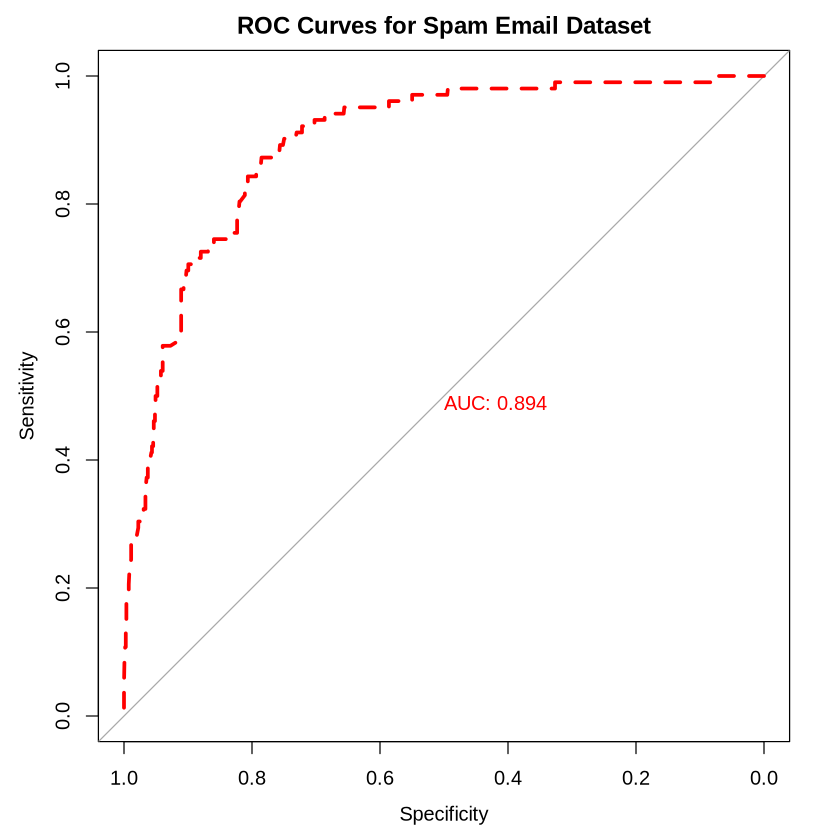

In [9]:
print("LASSO feature selection:")
coef(email_cv_lambda_LASSO, s = "lambda.min")

print("Chosen Model:")
summary(chosen_model)


plot(roc_glm, print.auc = TRUE, col = "red", lwd = 3, lty = 2, main = "ROC Curves for Spam Email Dataset")

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Main developer: Stephen Hong

pred_probs_glm <- predict(
    chosen_model,
    newdata = email_testing,
    type = "response"
)

# code adapted from worksheet 10
email_pred_class <- round(pred_probs_glm, 0)

email_confusion_matrix <- confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_testing$spam),
    positive = "1"
)

# show confusion matrix
print("Confusion matrix:")
email_confusion_matrix$table

# store confusion matrix metrics in a table
conf_mat_stats <- tibble(Sensitivity = c(email_confusion_matrix$byClass["Sensitivity"]),
                         Specificity = c(email_confusion_matrix$byClass["Specificity"]),
                         Precision = c(email_confusion_matrix$byClass["Precision"]),
                         Recall = c(email_confusion_matrix$byClass["Recall"]),
                         Accuracy = c(email_confusion_matrix$overall["Accuracy"]),
                         Kappa = c(email_confusion_matrix$overall["Kappa"]))
conf_mat_stats

[1] "Confusion matrix:"


          Reference
Prediction    0    1
         0 1072   87
         1    3   15

Sensitivity,Specificity,Precision,Recall,Accuracy,Kappa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1470588,0.9972093,0.8333333,0.1470588,0.9235344,0.2299808


## Discussion

## References
Cranor, L. F., & LaMacchia, B. A. (1998). Spam! *Communications of the ACM, 41*(8), 74–83. https://doi.org/10.1145/280324.280336 